In [1]:
import jax.numpy as np

from abc import ABC, abstractmethod
from collections.abc import Callable
from jax import Array

from jax.scipy.linalg import expm
from math import comb, factorial

from ode_filters.priors import MaternPrior, IWP, taylor_mode_initialization, JointPrior
from ode_filters.filters import ekf1_sqr_loop, rts_sqr_smoother_loop
from ode_filters.measurement import ODEInformation, ODEmeasurement
from tqdm import tqdm

import matplotlib.pyplot as plt
from functools import partial

import jax.random as jrandom

In [2]:
q, d = 2, 1
D = d*(q+1)
xi = np.eye(d) * 10
#prior = IWP(q, d, Xi=xi)
prior = MaternPrior(q, d, 1.1, Xi=xi)
ts, h = np.linspace(0, 10, 21, retstep=True)
mu_0 = np.zeros(D)
Sigma_0 = np.eye(D)*1e-12

# Initialize RNG key
key = jrandom.PRNGKey(0)

# Number of trajectory samples
k = 5

# Storage for all trajectories
trajectories = []

# Repeat sampling k times
for _ in range(k):
    # Split key for this repetition
    key, subkey = jrandom.split(key)
    x_0 = jrandom.multivariate_normal(subkey, mean=mu_0, cov=Sigma_0)
    x_s = [x_0]
    A_h, Q_h = prior.A(h), prior.Q(h)
    
    # Simulate trajectory
    for _ in ts:
        key, subkey = jrandom.split(key)
        mu_nxt = A_h @ x_s[-1]
        x_nxt = jrandom.multivariate_normal(subkey, mean=mu_nxt, cov=Q_h)
        x_s.append(x_nxt)
    
    trajectories.append(np.array(x_s))

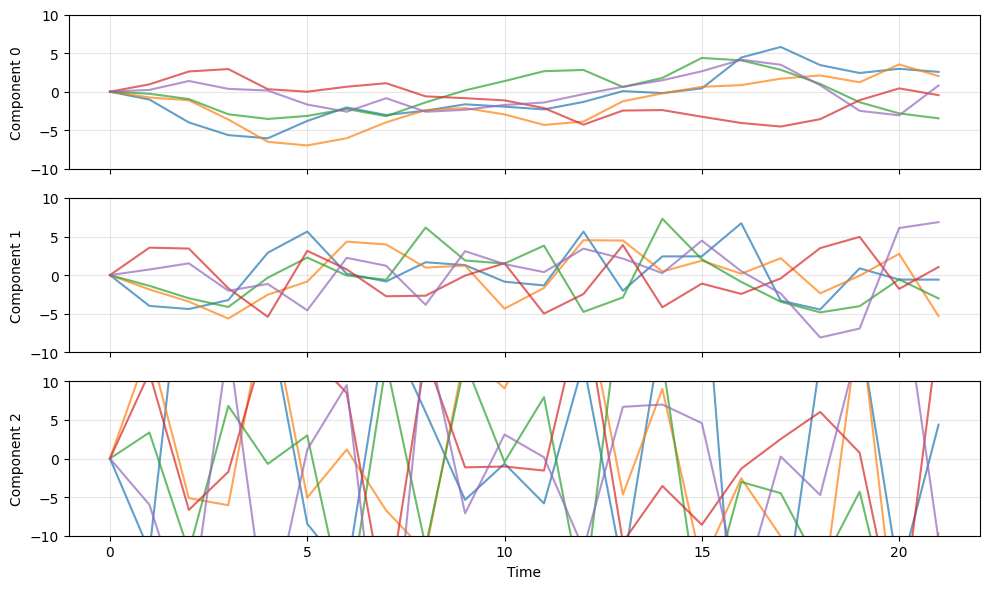

In [3]:
# Convert to array for easier manipulation
trajectories = np.array(trajectories)  # Shape: (k, len(ts)+1, D)

# Plot all trajectories in D subplots (one per state component)
fig, axes = plt.subplots(D, 1, figsize=(10, 2*D), sharex=True)

for traj in trajectories:
    for i in range(D):
        axes[i].plot(traj[0:, i], alpha=0.7)

for i in range(D):
    axes[i].set_ylabel(f'Component {i}')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-10,10])

axes[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

In [4]:
def x_analytical(t, x0=0.01):
    return x0 / (x0 + (1 - x0) * np.exp(-t))

#time
tspan = [0, 10]
N = 42

# Time points
ts = np.linspace(tspan[0], tspan[1], N + 1)

# Sample with noise
key = jrandom.PRNGKey(42)
noise_std = 0.05

x_true = x_analytical(ts[1:])
noise = noise_std * jrandom.normal(key, shape=x_true.shape)
x_obs = x_true + noise

# Format for measurement model
z = x_obs.reshape(-1, 1)       # Shape: (N, 1) - observation values
z_t = ts[1:]                   # Shape: (N,) - observation times
A = np.array([[1.0, 0.]])      # Shape: (1, 1) - observation matrix (direct observation of x)

In [5]:
def vf(x, *, t):
    u = x[-1]
    x_new = x[0]
    return u * x_new * (1 - x_new)

#time
tspan = [0, 10]
N = 10*42 

#latent force
u0 = np.array([1.])
d_u = u0.shape[0]
q_u = 2

#this could all be part of the prior itself
D_u = (q_u+1)*d_u
xi_u = 0.00001 * np.eye(d_u)
prior_u = IWP(q_u, d_u, Xi=xi_u)
#prior_u = MaternPrior(q_u, d_u, 10, Xi=xi_u)
mu_0_u = np.concat([u0, np.zeros(q_u*d_u)])
Sigma_0_sqr_u = np.zeros((D_u, D_u))

#state
x0 = np.array([0.01])
d_x = x0.shape[0]
q_x = 2
D_x = (q_x + 1) * d_x
xi_x = 10000000. * np.eye(d_x)
prior_x = IWP(q_x, d_x, Xi=xi_x)

def vf_x(x_prime, *, t):
    """Vector field for x_prime only, with alpha fixed to u_0."""
    alpha = u0[0]  # Extract scalar from u_0
    return alpha * x_prime * (1 - x_prime)

mu_0_x, Sigma_0_sqr_x = taylor_mode_initialization(vf_x, x0, q_x)

In [6]:
mu_0 = np.concat([mu_0_x, mu_0_u])
zeros = np.zeros((D_x, D_u))
Sigma_0_sqr = np.block([[Sigma_0_sqr_x, zeros],[zeros.T, Sigma_0_sqr_u]])
prior = JointPrior(prior_x, prior_u)
#measure = ODEInformation(vf, prior.E0, prior.E1)

In [21]:
measure = ODEmeasurement(vf, prior.E0, prior.E1, A, z, z_t)

In [22]:
measure.R_measure *= 1e5
print(measure.R)
print(measure.R_measure)

[[0.]]
[[0.  0. ]
 [0.  0.1]]


In [23]:
(
    m_seq,
    P_seq_sqr,
    m_pred_seq,
    P_pred_seq_sqr,
    G_back_seq,
    d_back_seq,
    P_back_seq_sqr,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop(mu_0, Sigma_0_sqr, prior, measure, tspan, N)

In [24]:

m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop(
    m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N
)

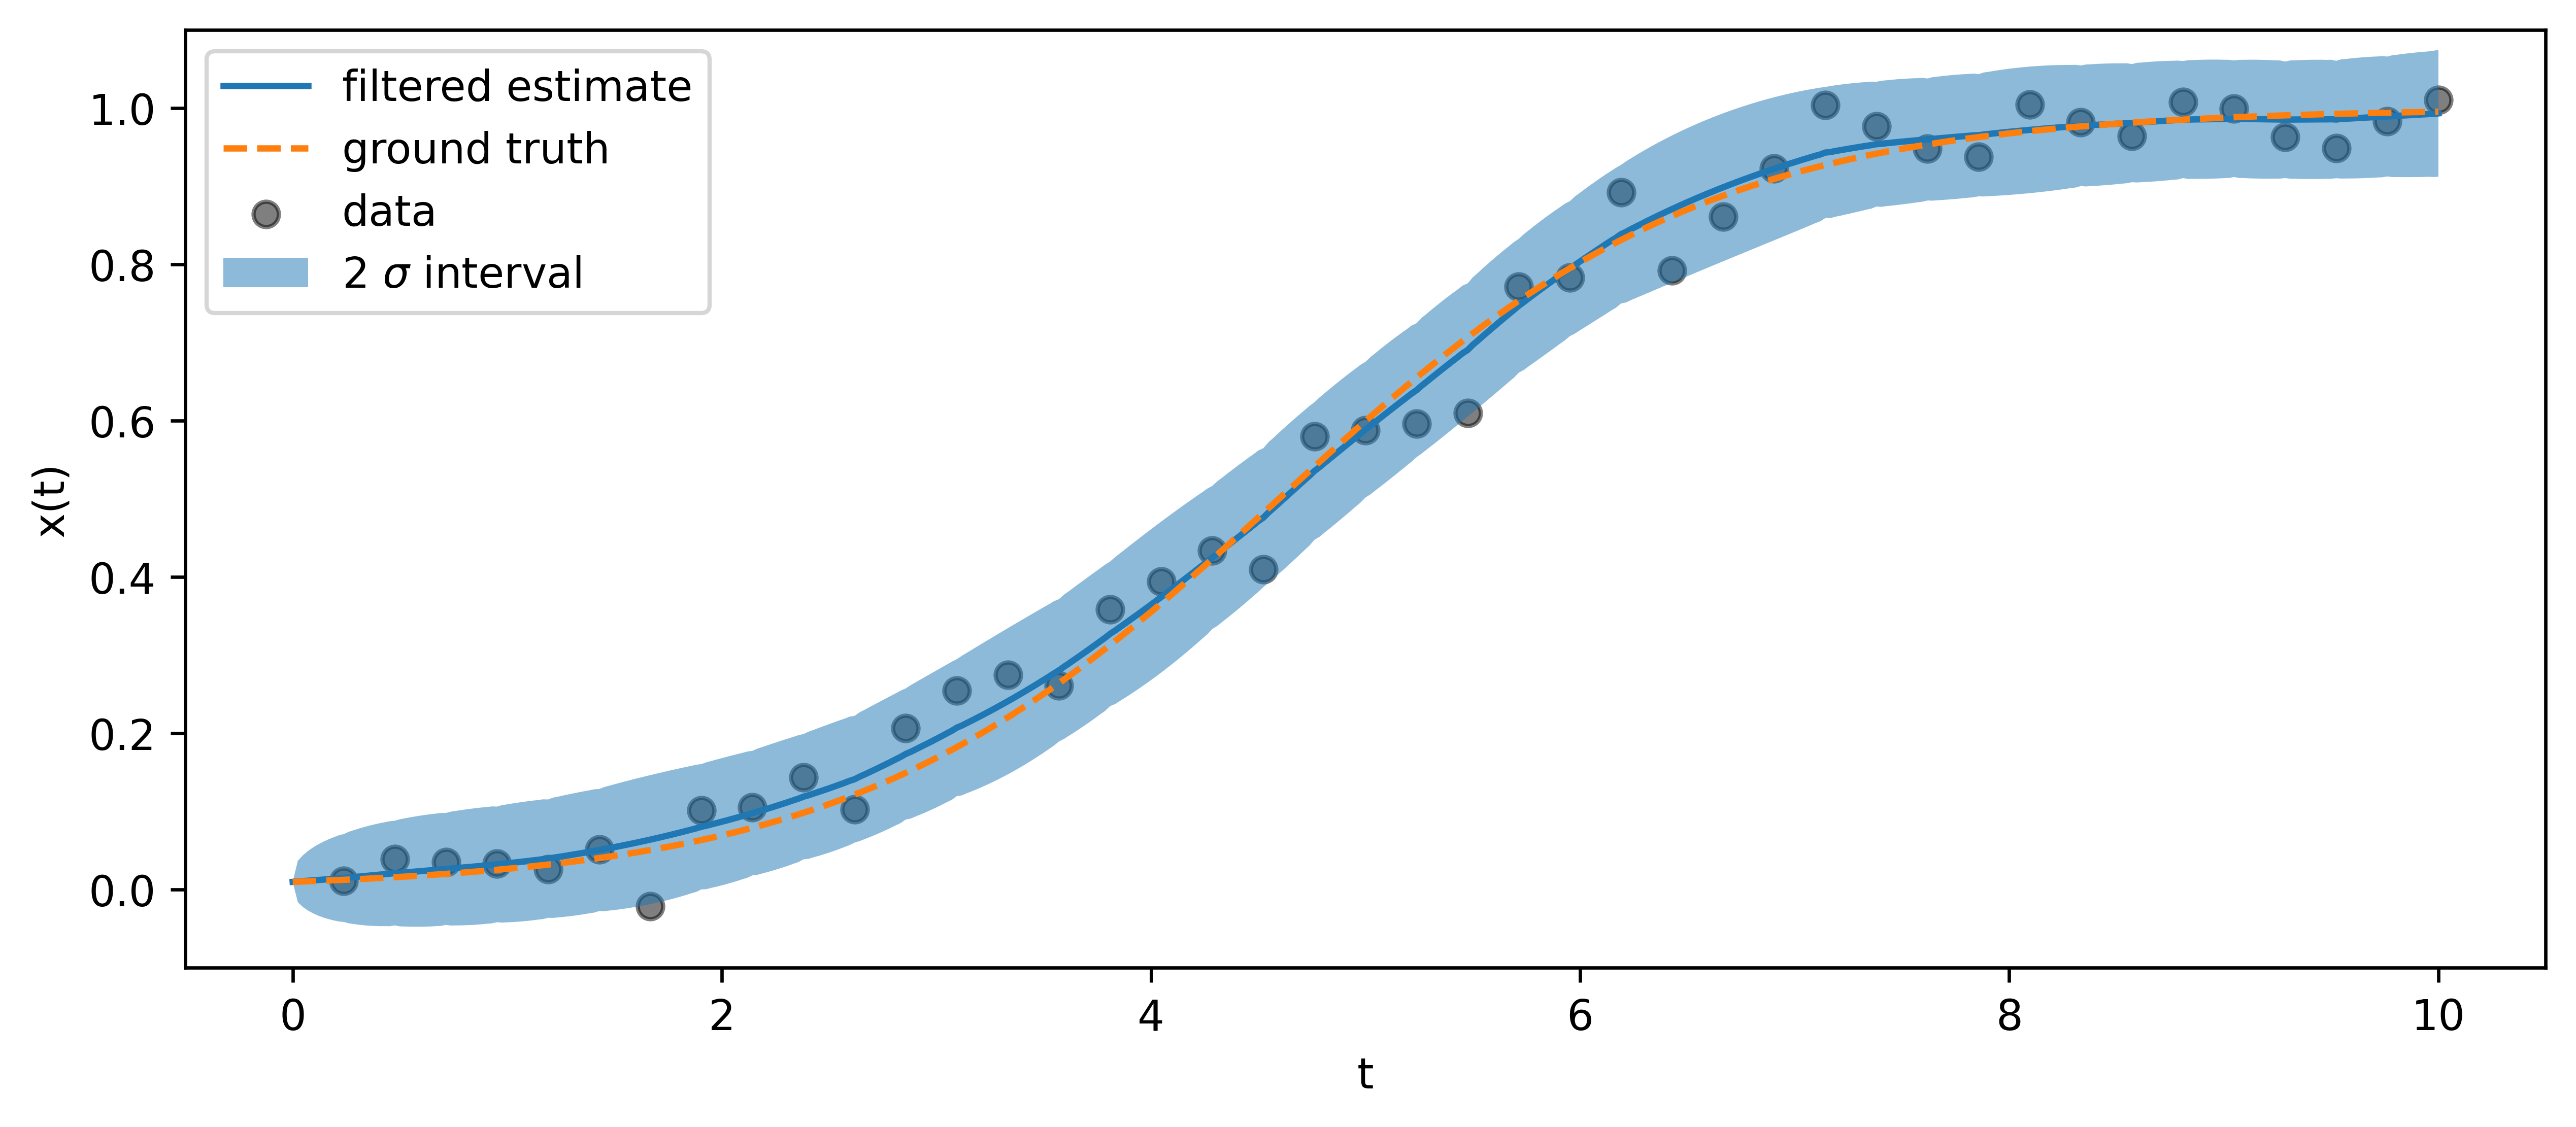

In [25]:
m_seq = np.array(m_smoothed)
P_seq_sqr = np.array(P_smoothed_sqr)

ts = np.linspace(tspan[0], tspan[1], N + 1)
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, 0], label="filtered estimate")
plt.plot(ts, x_analytical(ts), label="ground truth", linestyle="--")
plt.scatter(z_t, z, color="black", alpha=0.5, label="data")
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, 0, 0])
plt.fill_between(
    ts,
    m_seq[:, 0] - margin,
    m_seq[:, 0] + margin,
    alpha=0.5,
    label=r"2 $\sigma$ interval",
)
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

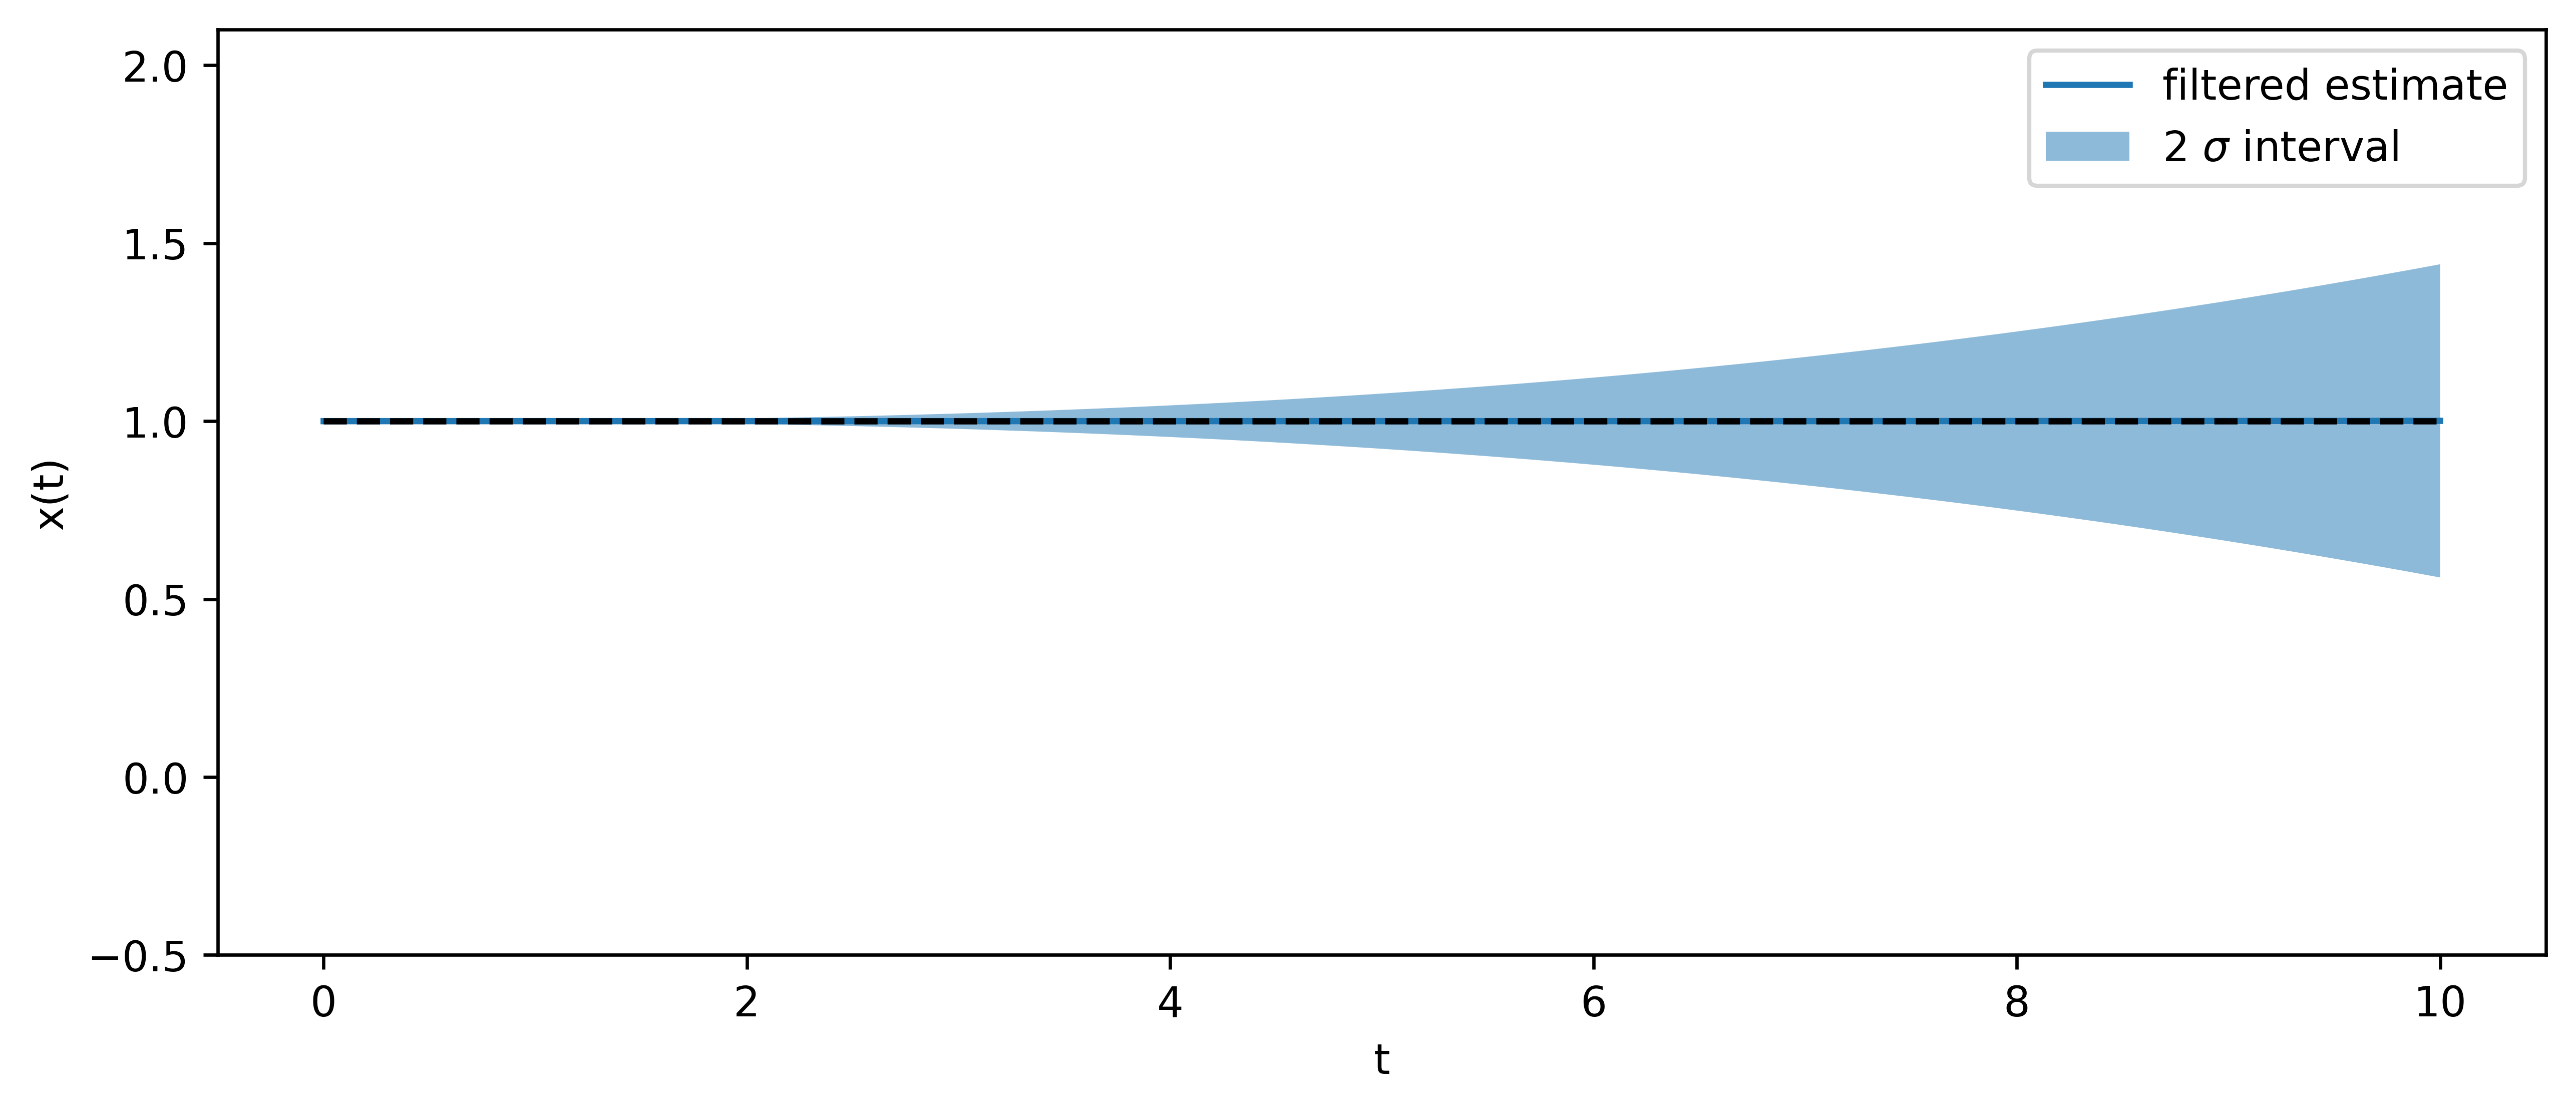

In [26]:
id = 3

ts = np.linspace(tspan[0], tspan[1], N + 1)
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, id], label="filtered estimate")
plt.plot(ts, np.ones_like(ts), linestyle="--", color="black")
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, id, id])
plt.fill_between(
    ts,
    m_seq[:, id] - margin,
    m_seq[:, id] + margin,
    alpha=0.5,
    label=r"2 $\sigma$ interval",
)
plt.ylim([-0.5, 2.1])
plt.legend()
plt.show()